<a href="https://colab.research.google.com/github/nefario7/cmu-deeplearning/blob/working-hw4/Homework%204/Multihead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Drive and Kaggle Data

In [ ]:
from IPython.display import clear_output 
# NOTWORKING
# ! apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# ! add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# ! apt-get update -qq 2>&1 > /dev/null
# ! apt-get -y install -qq google-drive-ocamlfuse fuse

# from google.colab import auth
# import getpass
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# creds = GoogleCredentials.get_application_default()


# ! google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# ! echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# WORKING
!sudo add-apt-repository -y ppa:alessandro-strada/ppa
!sudo apt update
!sudo apt install google-drive-ocamlfuse
!google-drive-ocamlfuse

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/alessandro-strada/ppa/ubuntu bionic InRelease [15.4 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,733 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:14 http:

In [ ]:
!sudo apt-get install w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser 

% cd /content
! mkdir cmudrive
% cd ..
! google-drive-ocamlfuse /content/cmudrive
! pip install kaggle wandb torch-summary
! mkdir ~/.kaggle
! cp /content/cmudrive/IDL/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! pip install --upgrade --force-reinstall --no-deps kaggle 
! kaggle config set -n path -v /content

! wandb login 4bdbe9c204105e1264fe3f54df2732fd1fff8040
! pip install python-Levenshtein
! pip install torchsummaryX
! pip install wget
! pip install adamp
clear_output()

In [ ]:
! kaggle competitions download -c 11-785-s22-hw4p2

! unzip -q /content/competitions/11-785-s22-hw4p2/11-785-s22-hw4p2.zip -d /content
! mv /content/hw4p2_student_data/hw4p2_student_data /content/actual_data
! mv /content/hw4p2_simple/hw4p2_simple /content/toy_data
! rm -rf /content/hw4p2_student_data
! rm -rf /content/hw4p2_simple

clear_output()

## Libraries and Initial Processing

In [ ]:
import os
import sys
import csv
import yaml
import wandb
import datetime
import time
import pandas as pd
import numpy as np
import Levenshtein
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torchsummaryX import summary
# from torchsummary import summary
from adamp import AdamP
from tqdm import tqdm

import warnings
import multiprocessing
warnings.filterwarnings('ignore')

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

cuda = torch.cuda.is_available()

print(cuda, sys.version)

device = torch.device("cuda" if cuda else "cpu")
NUM_WORKERS = 4 if cuda else 0
print("Cuda = " + str(cuda)+" with num_workers = " + str(NUM_WORKERS))
np.random.seed(11785)
torch.manual_seed(11785)

# The labels of the dataset contain letters in LETTER_LIST.
# You should use this to convert the letters to the corresponding indices
# and train your model with numerical labels.
LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']

def header(head):
    print("-"*80)
    print(f"\t\t\t\t{head.upper()}")
    print("-"*80)

True 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Cuda = True with num_workers = 4


In [ ]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    based on LETTER_LIST

    Args:
        letter_list: LETTER_LIST

    Return:
        letter2index: Dictionary mapping from letters to indices
        index2letter: Dictionary mapping from indices to letters
    '''
    letter2index = dict(zip(letter_list, list(range(len(letter_list)))))
    index2letter = dict(zip(list(range(len(letter_list))), letter_list))
    # TODO
    return letter2index, index2letter
    

def transform_index_to_letter(batch_indices):
    '''
    Transforms numerical index input to string output by converting each index 
    to its corresponding letter from LETTER_LIST

    Args:
        batch_indices: List of indices from LETTER_LIST with the shape of (N, )
    
    Return:
        transcripts: List of converted string transcripts. This would be a list with a length of N
    '''
    transcripts = []
    for i, indices in enumerate(batch_indices):
        transcript_string = ''.join([LETTER_LIST[k] for k in indices])
        transcripts.append(transcript_string)
        
    return transcripts
        
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [ ]:
print(index2letter)

{0: '<sos>', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z', 27: "'", 28: ' ', 29: '<eos>'}


# Dataset and Dataloading (TODO)

You will need to implement the Dataset class by your own. You can implement it similar to HW3P2. However, you are welcomed to do it your own way if it is more comfortable or efficient.

Note that you need to use LETTER_LIST to convert the transcript into numerical labels for the model.


Example of raw transcript:

    ['<sos>', 'N', 'O', 'R', 'T', 'H', 'A', 'N', 'G', 'E', 'R', ' ','A', 'B', 'B', 'E', 'Y', '<eos>']

Example of converted transcript ready to process for the model:

    [0, 14, 15, 18, 20, 8, 1, 14, 7, 5, 18, 28, 1, 2, 2, 5, 25, 29]


In [ ]:
# transcripts = os.listdir(r"/content/actual_data/train/transcript")
# temp = np.load(os.path.join(r"/content/actual_data/train/transcript", transcripts[0]))
# print(np.array([*map(letter2index.get, temp)]))

# y = np.load('/content/toy_data/dev_transcripts.npy', allow_pickle=True)
# print(type(y))
# print(len(y))

In [ ]:
class LibriSamples(torch.utils.data.Dataset):
    def __init__(self, data_path=r"/content/actual_data", partition="train"):
        self.test = True if partition == "test" else False

        if data_path == '/content/actual_data':
            partition_path = os.path.join(data_path, partition)
            self.X_dir = os.path.join(partition_path, 'mfcc')
            self.Y_dir = os.path.join(partition_path, 'transcript')

            if self.test:
                with open(os.path.join(partition_path, 'test_order.csv'),"r") as f:
                    self.X_files = list(csv.reader(f))[1:]
                self.X_data = [np.load(os.path.join(self.X_dir, xfile[0])) for xfile in tqdm(self.X_files, desc="MFCC", position=0, leave=True)]
            else:
                self.X_files = os.listdir(self.X_dir)
                self.Y_files = os.listdir(self.Y_dir)

                self.X_data = [np.load(os.path.join(self.X_dir, xfile)) for xfile in tqdm(self.X_files, desc="MFCC", position=0, leave=True)]
                self.Y_data = [np.array([*map(letter2index.get, np.load(os.path.join(self.Y_dir, yfile)))]) for yfile in tqdm(self.Y_files, desc="Transcript", position=0, leave=True)]
        else:
            self.X_data = np.load(os.path.join(data_path, partition + '.npy'), allow_pickle=True)
            transcripts = np.load(os.path.join(data_path, partition + '_transcripts.npy'), allow_pickle=True)
            self.Y_data = [np.array([*map(letter2index.get, t)]) for t in transcripts]

        if not self.test:
            assert(len(self.X_data) == len(self.Y_data))

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        X = self.X_data[idx]
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        if self.test:
            return torch.from_numpy(X)
            # return torch.from_numpy(X).type(torch.LongTensor)
        else:
            Y = self.Y_data[idx]
            return torch.from_numpy(X), torch.from_numpy(Y)
            # return torch.from_numpy(X).type(torch.LongTensor), torch.from_numpy(Y).type(torch.LongTensor)
    
    def collate_fn(self, batch):
        if self.test:
            batch_x = [x for x in batch]
            batch_x_pad = pad_sequence(batch_x, batch_first=True)
            lengths_x = [len(x) for x in batch_x]
            return batch_x_pad, torch.tensor(lengths_x)
        else:
            batch_x = [x for x,_ in batch]
            batch_y = [y for _,y in batch]
            batch_x_pad = pad_sequence(batch_x, batch_first=True)
            batch_y_pad = pad_sequence(batch_y, batch_first=True, padding_value=letter2index['<eos>'])
            lengths_x = [len(x) for x in batch_x]
            lengths_y = [len(y) for y in batch_y]
            
            return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)

In [ ]:
# batch_size = 64

# train_data = LibriSamples(data_path=r"/content/toy_data", partition='train')
# val_data = LibriSamples(data_path=r"/content/toy_data", partition='dev')
# # test_data = LibriSamples(partition='test')

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, collate_fn = train_data.collate_fn, num_workers=2)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn = val_data.collate_fn, num_workers=2)
# # test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn = test_data.collate_fn)

# print("Batch size: ", batch_size)
# print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
# print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
# # print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

# Model

#### pBLSTM

In [ ]:
from torch.autograd import Variable
class LockedDropout(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.dropout = 0.6
    def forward(self, x):
        if self.training and self.dropout:
            m = x.data.new(1, x.shape[1], x.shape[2]).bernoulli_(1 - self.dropout)
            mask = Variable(m, requires_grad=False) / (1 - self.dropout)
            mask = mask.expand_as(x)
            return mask * x
        return x

In [ ]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed
    2. Truncate the input length dimension by concatenating feature dimension
        (i) How should  you deal with odd/even length input? 
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''
    def __init__(self, input_dim, hidden_dim, dropout=0, downsampling=2, locked_dropout=0.0):
        super(pBLSTM, self).__init__()
        self.downsampling = downsampling
        self.locked_dropout = locked_dropout

        self.blstm = nn.LSTM(
            input_size=input_dim, 
            hidden_size=hidden_dim, 
            num_layers=1, 
            dropout=dropout, 
            bidirectional=True, 
            batch_first=True
            )
        if self.locked_dropout:
            self.ld = LockedDropout(self.locked_dropout)

    def forward(self, x):
        padded_x, padded_x_len = rnn_utils.pad_packed_sequence(x, batch_first=True)
        padded_x = padded_x.to(device)

        # print(padded_x.shape, padded_x_len.shape)
        timesteps = padded_x.size(1)
        trim =  timesteps - timesteps % self.downsampling
        padded_x = padded_x[:, :trim, :]
        padded_x_len = padded_x_len // self.downsampling
        # print("Downsampled", padded_x.shape, padded_x_len.shape)
        
        B, T, F = padded_x.size()
        # Simple
        reshaped_x = padded_x.reshape(B, T // self.downsampling, F * self.downsampling)
        reshaped_x = reshaped_x.to(device)

        if self.locked_dropout:
            reshaped_x = self.ld.forward(reshaped_x)
        # Alternative with mean/ max
        # reshaped_x = padded_x.reshape(B, T // self.downsampling, self.downsampling, F)
        # reshaped_x = torch.mean(reshaped, dim=2)
        # reshaped_x = torch.max(reshaped, dim=2)

        packed_x = rnn_utils.pack_padded_sequence(reshaped_x, lengths=padded_x_len, batch_first=True, enforce_sorted=False)

        out, _ = self.blstm(packed_x.to(device))
        return out

In [ ]:
# b, t, f = x.shape
# res = x.reshape(b, t // 2, 2, f)

# print(res[0][0], res.shape)

# men = torch.mean(res, 2)
# print(men[0][0], men.shape)

#### Encoder

In [ ]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.

    '''
    def __init__(self, input_dim, encoder_hidden_dim, encoder_layers=1, key_value_size=128, dropout=0.2, downsampling=2, locked_dropout=0.0):
        super(Encoder, self).__init__()
        # The first LSTM layer at the bottom
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=encoder_hidden_dim, num_layers=encoder_layers, bidirectional=True, batch_first=True)

        # Define the blocks of pBLSTMs
        # Dimensions should be chosen carefully
        # Hint: Bidirectionality, truncation...
        self.pblstm = nn.Sequential(
            pBLSTM(encoder_hidden_dim*2*downsampling, encoder_hidden_dim, dropout, downsampling, locked_dropout=locked_dropout),
            pBLSTM(encoder_hidden_dim*2*downsampling, encoder_hidden_dim, dropout, downsampling, locked_dropout=locked_dropout),
            pBLSTM(encoder_hidden_dim*2*downsampling, encoder_hidden_dim, dropout, downsampling, locked_dropout=0.0),
        )
         
        # The linear transformations for producing Key and Value for attention
        # Hint: Dimensions when bidirectional lstm?
        self.key_network_1 = nn.Linear(encoder_hidden_dim * 2, key_value_size)
        self.value_network_1 = nn.Linear(encoder_hidden_dim * 2, key_value_size)

        self.key_network_2 = nn.Linear(encoder_hidden_dim * 2, key_value_size)
        self.value_network_2 = nn.Linear(encoder_hidden_dim * 2, key_value_size)
        
        self.weight_initialization()

    def forward(self, x, x_len):
        """
        1. Pack your input and pass it through the first LSTM layer (no truncation)
        2. Pass it through the pyramidal LSTM layer
        3. Pad your input back to (B, T, *) or (T, B, *) shape
        4. Output Key, Value, and truncated input lens

        Key and value could be
            (i) Concatenated hidden vectors from all time steps (key == value).
            (ii) Linear projections of the output from the last pBLSTM network.
                If you choose this way, you can use the final output of
                your pBLSTM network.
        """
        # print("x: {}, x_len: {}".format(x.shape, x_len.shape))
        packed_input = rnn_utils.pack_padded_sequence(x, lengths=x_len, batch_first=True, enforce_sorted=False)

        lstm_output, _ = self.lstm(packed_input.to(device))
        lstm_output = lstm_output.to(device)
        pblstm_output = self.pblstm(lstm_output)
        pblstm_output = pblstm_output.to(device)

        encoder_output, encoder_lens = rnn_utils.pad_packed_sequence(pblstm_output, batch_first=True)

        key_1 = self.key_network_1(encoder_output.to(device)).to(device)
        value_1 = self.value_network_1(encoder_output.to(device)).to(device)

        key_2 = self.key_network_2(encoder_output.to(device)).to(device)
        value_2 = self.value_network_2(encoder_output.to(device)).to(device)

        return key_1, key_2, value_1, value_2, encoder_lens

    def weight_initialization(self):
        for m in self.modules():
            if isinstance(m, nn.LSTM):
                nn.init.xavier_uniform_(m.weight_ih_l0, gain=0.1)
                nn.init.xavier_uniform_(m.weight_ih_l0_reverse, gain=0.1)
                nn.init.xavier_uniform_(m.weight_hh_l0, gain=0.1)
                nn.init.xavier_uniform_(m.weight_hh_l0_reverse, gain=0.1)
                # print(m.__dict__["_parameters"].keys())

#### Attention

In [ ]:
def plot_attention(attention):
    # utility function for debugging
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key and value from encoder and query from decoder.
    Here are different ways to compute attention and context:
    1. Dot-product attention
        energy = bmm(key, query) 
        # Optional: Scaled dot-product by normalizing with sqrt key dimension
        # Check "attention is all you need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore...
    2. Cosine attention
        energy = cosine(query, key) # almost the same as dot-product xD 
    3. Bi-linear attention
        W = Linear transformation (learnable parameter): d_k -> d_q
        energy = bmm(key @ W, query)
    4. Multi-layer perceptron
        # Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4
    
    After obtaining unnormalized attention weights (energy), compute and return attention and context, i.e.,
    energy = mask(energy) # mask out padded elements with big negative number (e.g. -1e9)
    attention = softmax(energy)
    context = bmm(attention, value)

    5. Multi-Head Attention
        # Check "attention is all you need" Section 3.2.2
        h = Number of heads
        W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
        W_O: d_v -> d_v

        Reshape K: (B, T, d_k)
        to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
        Reshape V: (B, T, d_v)
        to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
        Reshape Q: (B, d_q)
        to (B, h, d_q // h)

        energy = Q @ K^T
        energy = mask(energy)
        attention = softmax(energy)
        multi_head = attention @ V
        multi_head = multi_head reshaped to (B, d_v)
        context = multi_head @ W_O
    '''
    def __init__(self):
        super(Attention, self).__init__()
        # Optional: dropout

    def attention_calculation(self, key, query, value, mask):
        energy = torch.bmm(key, query.unsqueeze(dim=2)) # (B x S x 128) * (B x 128 x 1) -> (B x 260 x 1)
        energy = energy.squeeze(dim=2)  # (B x S)

        masked_energy = energy * mask.int().float()
        # masked_energy = energy.masked_fill(mask, -1e9)
        
        normal_energy = masked_energy / np.sqrt(key.size(2)) # (B, S)

        attention = F.softmax(normal_energy, dim=1) # (B, S)
        # print(attention.shape)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)   # (B x 1 x S) * (B x S x 128) -> (B x S)
        # print("context", context.shape, "attention", attention.shape)
        return attention, context

    def forward(self, query, key_1, key_2, value_1, value_2, mask):
        """
        input:
            key: (batch_size, seq_len, d_k) #(N, S, 128)
            value: (batch_size, seq_len, d_v) #(N, S, 128)
            query: (batch_size, d_q)
        * Hint: d_k == d_v == d_q is often true if you use linear projections
        return:
            context: (batch_size, key_val_dim)
        
        """
        attention_1, context_1 = self.attention_calculation(key_1, query, value_1, mask)
        attention_2, context_2 = self.attention_calculation(key_2, query, value_2, mask)

        attention = attention_1 + attention_2
        context = context_1 + context_2
        attention /= 2.0
        context /= 2.0

        return context, attention
        # we return attention weights for plotting (for debugging)

In [ ]:
# q = torch.randn(64, 128)
# energy = torch.bmm(k, q.unsqueeze(dim=2)) # (B x S x 128) * (B x 128 x 1) -> (B x 260 x 1)
# print("Energy : ", energy.shape)
# energy = energy.squeeze(dim=2)  # (B x S)
# print("Energy : ", energy.shape)
# masked_energy = energy * mask.int().float()
# print("Masked Energy : ", energy.shape)
# normal_energy = masked_energy / np.sqrt(k.size(2)) # (B, S)
# print("Normal Energy : ", energy.shape)

# attention = F.softmax(normal_energy, dim=1) # (B, S)
# context = torch.bmm(attention.unsqueeze(1), v).squeeze(1)   # (B x 1 x S) * (B x S x 128) -> (B x S)
# print("Attention : ", attention.shape)
# print("Value : ", v.shape)
# print("Context : ", torch.bmm(attention.unsqueeze(1), v).squeeze(1)

# print(type(energy))
# print(mask)
# print(type(energy * mask.int().float()))

#### Decoder

In [ ]:
# encoder = Encoder(13, 64)
# k, v, l = encoder(x, lx)
# print(k.shape, v.shape, l.shape)
# print(k[0], v[0], l)

# B, T, dkv = k.shape
# mask =torch.arange(end=T).unsqueeze(0) <= l.unsqueeze(1)
# mask.shape

In [ ]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the last LSTMCell can be used as a query for calculating attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128): # 0 enforcing = False
        super(Decoder, self).__init__()
        self.key_value_size = key_value_size
        self.vocab_size = vocab_size

        # Hint: Be careful with the padding_idx
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=letter2index['<eos>'])
        self.lstm1 = nn.LSTMCell(input_size=embed_dim + key_value_size, hidden_size=decoder_hidden_dim)  #concatenate(transcript and context)
        self.lstm2 = nn.LSTMCell(input_size=decoder_hidden_dim, hidden_size=key_value_size)
        self.attention = Attention()     
        self.character_prob = nn.Linear(key_value_size + key_value_size, vocab_size) #: d_v -> vocab_size

        # Weight tying
        self.character_prob.weight = self.embedding.weight

    def forward(self, key_1, key_2, value_1, value_2, encoder_len, y=None, mode='train', teacher_enforcing=0.95):
        '''
        Args:
            key :(B, T, d_k) - Output of the Encoder (possibly from the Key projection layer)
            value: (B, T, d_v) - Output of the Encoder (possibly from the Value projection layer)
            y: (B, text_len) - Batch input of text with text_length
            mode: Train or eval mode for teacher forcing
        Return:
            predictions: the character perdiction probability 
        '''
        B, key_seq_max_len, key_value_size = key_1.shape

        if mode == 'train':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y)
        else:
            max_len = 600

        # TODO: Create the attention mask here (outside the for loop rather than inside) to aviod repetition
        B, T, dkv = key_1.shape
        mask = torch.arange(end=T).unsqueeze(0) <= encoder_len.unsqueeze(1) # range(T).shape(T, 1) <= len.shape(B, 1) i.e. max_len for each batch  
        mask = mask.to(device) # (B x T)
        
        predictions = []
        # This is the first input to the decoder. What should the fill_value be?
        prediction = torch.full((B,), fill_value=letter2index['<sos>'], device=device)
        # The length of hidden_states vector should depend on the number of LSTM Cells defined in init. The paper uses 2
        hidden_states = [None, None] 
        
        # TODO: Initialize the context
        # context = torch.zeros((B, dkv)).to(device)
        context = torch.ones((B, dkv)).to(device)

        attention_plot = [] # this is for debugging

        # print("char_embeddings : ", char_embeddings.shape)
        # print("mask : ", mask.shape)
        # print("prediction : ", prediction.shape)
        # print("context : ", context.shape)
        # print("\n-----------------------LOOP STARTS")

        for i in range(max_len):
            if mode == 'train':
                # TODO: Implement Teacher Forcing
                enforce = True if np.random.random() > (1 - teacher_enforcing) else False
                if enforce:
                    if i == 0:  # First time step
                        # Hint: How did you initialize "prediction" variable above?
                        char_embed = self.embedding(prediction)
                    else:
                        char_embed = char_embeddings[:, i-1, :]
                        # Otherwise, feed the label of the **previous** time step
                else:
                    char_embed = self.embedding(prediction)
            else:
                char_embed = self.embedding(prediction)
            
            y_context = torch.cat([char_embed, context], dim=1)
            # context and hidden states of lstm 1 from the previous time step should be fed
            # Input (input feature, [hidden state, cell state])
            # Output (next hidden state, next cell state)
            # hidden states of lstm1 and hidden states of lstm2 from the previous time step should be fed
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])  
            hidden_states[1] = self.lstm2(hidden_states[0][0], hidden_states[1])
            query = hidden_states[1][0]
            
            # Compute attention from the output of the second LSTM Cell
            context, attention = self.attention(query, key_1, key_2, value_1, value_2, mask)
            # print(attention.shape)

            attention_plot.append(attention[0].detach().cpu())
            
            output_context = torch.cat([query, context], dim=1)
            prediction = self.character_prob(output_context)
            predictions.append(prediction.unsqueeze(dim=1))
            
            prediction = prediction.argmax(dim=1)
        
        # Concatenate the attention and predictions to return
        attentions = torch.stack(attention_plot, dim=0)
        predictions = torch.cat(predictions, dim=1)
        return predictions, attentions

#### Seq2Seq

In [ ]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(
        self, 
        input_dim, 
        vocab_size, 
        encoder_hidden_dim, 
        decoder_hidden_dim, 
        embed_dim, 
        encoder_layers=1,
        key_value_size=128, 
        teacher_enforcing=None, 
        dropout=0.2, 
        downsampling=2,
        locked_dropout=0.0
        ): 
        # enforcing : 0 = False and 0.95 = True with 95% prob
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(
            input_dim, 
            encoder_hidden_dim, 
            encoder_layers, 
            key_value_size, 
            dropout, 
            downsampling, 
            locked_dropout
            )
        
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size)

        # for name, param in self.named_parameters():
        #     if 'weight' in name:
        #         nn.init.orthogonal_(param.data)
        #     else:
        #         nn.init.constant_(param.data, 0)

    def forward(self, x, x_len, y=None, mode='train', teacher_enforcing=0.95):
        key_1, key_2, value_1, value_2, encoder_lens = self.encoder(x, x_len)
        # print("Encoder Output : ", key.shape, value.shape, encoder_len.shape)
        predictions, attentions = self.decoder(key_1, key_2, value_1, value_2, encoder_lens, y=y, mode=mode, teacher_enforcing=teacher_enforcing)
        # print("Decoder Output : ", predictions.shape, attentions.shape)

        return predictions, attentions

In [ ]:
train_data = LibriSamples(data_path=r"/content/toy_data", partition='train')
# train_data = LibriSamples(data_path=r"/content/actual_data", partition='train')
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, drop_last=False, collate_fn = train_data.collate_fn, num_workers=NUM_WORKERS)
for data in train_loader:
    x, y, lx, ly = data
    break

x, y, lx, ly = next(iter(train_loader))
print("Loader : ", x.shape, y.shape, lx.shape, ly.shape)

model_params = {
        'input_dim': 13,
        'vocab_size': len(LETTER_LIST), 
        'encoder_hidden_dim': 256, 
        'encoder_layers': 1,
        'decoder_hidden_dim': 512, 
        'embed_dim': 256, 
        'key_value_size': 128,
        'teacher_enforcing': 0.90,
        'dropout': 0.2,
        'downsampling': 1,
        'locked_dropout': 0.1
    }  # Weight Tying = True, Label Smoothing = 0.2
model = Seq2Seq(**model_params)
model = model.to(device)
print(model)
# print(x.shape, lx.shape, y.shape)
# summary(model, x.to(device), lx, y.to(device))
# preds, attentions = model(x.to(device), lx, y.to(device))
# print(preds.shape, attentions.shape)

Loader :  torch.Size([128, 34, 13]) torch.Size([128, 36]) torch.Size([128]) torch.Size([128])
Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(13, 256, batch_first=True, bidirectional=True)
    (pblstm): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(512, 256, batch_first=True, dropout=0.2, bidirectional=True)
        (ld): LockedDropout()
      )
      (1): pBLSTM(
        (blstm): LSTM(512, 256, batch_first=True, dropout=0.2, bidirectional=True)
        (ld): LockedDropout()
      )
      (2): pBLSTM(
        (blstm): LSTM(512, 256, batch_first=True, dropout=0.2, bidirectional=True)
      )
    )
    (key_network_1): Linear(in_features=512, out_features=128, bias=True)
    (value_network_1): Linear(in_features=512, out_features=128, bias=True)
    (key_network_2): Linear(in_features=512, out_features=128, bias=True)
    (value_network_2): Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(30, 256, padding_idx=29)
    (lstm1)

# Training Setup

In [ ]:
def beam_search():
    pass

def convert_to_string(batch_indices):
    transcripts = []
    for indices in batch_indices:
        transcript_string = ""
        for k in indices:
            if k == letter2index['<eos>']:
                break
            if k == letter2index['<sos>']:
                continue
            else:
                transcript_string += index2letter[k]
        transcripts.append(transcript_string)
    
    return transcripts

def calculate_levenshtein(predictions, target):
    batch_size = predictions.shape[0]

    predictions_text = convert_to_string(predictions.argmax(-1).detach().cpu().numpy())
    target_text = convert_to_string(target.detach().cpu().numpy())

    dist = 0
    for b in range(batch_size):
        dist += Levenshtein.distance(predictions_text[b], target_text[b])
    dist/=batch_size
    return dist, len(predictions_text)

def model_warm_up(trate, lev):
    if lev < 50 and trate > 0.5:
        trate *= 0.96
    return trate

In [ ]:
class ModelSetup:
    def __init__(self, config, save_path, toy=False):
        self.config = config
        self.log = config['log']
        self.save = config['save']
        self.toy = toy
        self.teacher_enforcing_rate = config["seq2seq"]["teacher_enforcing"]
        print(f"Saving : {self.save} and Logging : {self.log}")

        self.SAVE_DIR = save_path
        self.DATA_DIR = r"/content/actual_data" if not toy else r"/content/toy_data"

    def __gen_model_name(self):
        # Generate a model name based on config
        save_name = ''

        for key, val in self.config.items():
            abbr = key[0] if len(key) > 2 else key
            if key == 'optim':
                data = 'lr' + str(val["lr"])
                save_name += data
                break
            elif key == 'sched':
                continue
            elif key == 'seq2seq':
                seqdata = 'S2S'
                for k, v in val.items():
                    seqdata += '-' + k[0] +str(v)
                    save_name += seqdata 
            elif key == '':
                save_name += abbr + str(val)
                for key, val in self.config['seq2seq'].items():
                    save_name += '-' + str(val)
                save_name += '_'
            elif not isinstance(val, dict):
                data = abbr + str(val) + '_'
                save_name += data
                
        if self.config['randomize']:
            save_name = save_name + "-v" + str(np.random.randint(10, 1000))
        print("\nModel Name: ", save_name)
        self.model_name = save_name

    def __save_model_params(self, continue_train):
        # Create Model Directory
        save_path = os.path.join(self.SAVE_DIR, self.model_name)
        if not continue_train:
            try:
                os.mkdir(save_path)
            except FileExistsError:
                d = input("Model name already exists. Delete existing model? (y/n)")
                if d == 'y':
                    import shutil
                    shutil.rmtree(save_path)
                    os.mkdir(save_path)
                else:
                    print("Exiting!")
                    exit(0)
                    return None

            os.mkdir(os.path.join(save_path, 'Checkpoints'))
            # Saving Model Configuration
            with open(os.path.join(save_path, 'model_config.yaml'), 'w') as metadata:
                yaml.dump({'Experiment': self.config['']}, metadata, indent=4, default_flow_style=False)
                yaml.dump(self.config, metadata, indent=4, default_flow_style=False)
            print("Model to be saved at: ", save_path)
        self.model_path = save_path

    def __continue_train(self, chkpt):
        self.chkpt = chkpt
        assert chkpt is not None

        chkpt_path = os.path.join(self.model_path, 'Checkpoints', 'chkpt_' + str(chkpt) + '.pth')

        try:
            checkpoint = torch.load(chkpt_path)
        except FileNotFoundError:
            print("Checkpoint not found in the directory!")
            print("Incorrect: ", chkpt_path)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    def dataloaders(self): 
        self.train_data = LibriSamples(data_path=self.DATA_DIR, partition='train')
        self.val_data = LibriSamples(data_path=self.DATA_DIR, partition='dev')

        self.train_loader = DataLoader(
            self.train_data, 
            batch_size=self.config['batch_size'],
            shuffle=True,
            drop_last=True, 
            collate_fn = self.train_data.collate_fn, 
            num_workers=NUM_WORKERS,
            pin_memory=True
            ) 
        self.val_loader = DataLoader(
            self.val_data, 
            batch_size=self.config['batch_size'], 
            shuffle=False, 
            drop_last=True, 
            collate_fn = self.val_data.collate_fn, 
            num_workers=NUM_WORKERS,
            pin_memory=True
            )

    def save_checkpoint(self, epoch, model, optimizer, loss):
        print("Saving Checkpoint!")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, os.path.join(self.model_path, 'Checkpoints', 'chkpt_' + str(epoch) + '.pth'))

    def save_model(self, epoch=None, onnx=False):
        print("Saving Model!")
        try:
            if not self.save:
                self.__save_model_params()
            if epoch != self.config["epochs"] or epoch is None:
                name = os.path.join(self.model_path, "model_" + str(epoch) + ".pth")
            else:
                name = os.path.join(self.model_path, "model" + ".pth")
            torch.save(self.model.state_dict(), name)
        except:
            print("Model couldn't be saved!")

    def setup(self, continue_train=False, chkpt=None):
        header("Model Setup")

        # Model
        self.model = Seq2Seq(**self.config["seq2seq"]).to(device)
        # summary(self.model, x.to(device), lx, y.to(device))
        
        self.__gen_model_name()
        if self.save: self.__save_model_params(continue_train)

        # Loss
        self.criterion = nn.CrossEntropyLoss(reduction='none', label_smoothing=0.1)
        
        # Optimizer
        if self.config["optimizer"] == 'SGD':
            self.optimizer = optim.SGD(self.model.parameters(), **self.config['optim'])
        elif self.config["optimizer"] == "Adam":
            self.optimizer = optim.Adam(self.model.parameters(), **self.config['optim'])
        elif self.config["optimizer"] == "AdamW":
            self.optimizer = optim.AdamW(self.model.parameters(), **self.config['optim'])
        elif self.config["optimizer"] == "AdamP":
            # self.optimizer = AdamP(self.model.parameters(), **self.config['optim'])
            self.optimizer = AdamP(self.model.parameters(), lr=0.0002)

        self.chkpt = 0
        if continue_train: 
            self.__continue_train(chkpt)
            self.optimizer.param_groups[0]['lr'] = 0.0002

        # Scheduler
        if self.config["scheduler"] == 'CALR':
            self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=(len(self.train_loader) * self.config['epochs']))
        elif self.config["scheduler"] == 'RLRP':
            self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, **self.config['sched'])
        elif self.config["scheduler"] == 'MultiStep':
            self.scheduler = optim.lr_scheduler.MultiStepLR(self.optimizer, **self.config['sched'])
        elif self.config["scheduler"] == None:
            self.scheduler = None
        self.scaler = torch.cuda.amp.GradScaler()
    
    # Training Loop
    def train(self):
        self.model.train()
        batch_bar = tqdm(total=len(self.train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 
        running_loss = 0
        for i, (x, y, x_len, y_len) in enumerate(self.train_loader):
            torch.cuda.empty_cache()
            self.optimizer.zero_grad(set_to_none=True)
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            y_len = torch.tensor(y_len).to(device, non_blocking=True)

            with torch.cuda.amp.autocast():
                predictions, attentions = self.model(x, x_len, y, 'train', self.teacher_enforcing_rate)
            
                # 3) Generate a mask based on target length. This is to mark padded elements
                # so that we can exclude them from computing loss. Ensure that the mask is on the device and is the correct shape.
                max_len = torch.max(y_len)
                inst = y_len.shape[0]
                mask = torch.arange(0, max_len).repeat(inst, 1).to(device) >= y_len.reshape(inst, 1)
                # mask = torch.arange(0, max_len).repeat(inst, 1).to(device) < y_len.unsqueeze(1).expand(inst, max_len)
                # mask = mask.long()
                mask = mask.to(device, non_blocking=True)

                loss = self.criterion(predictions.permute(0, 2, 1), y)
                # loss = self.criterion(predictions.view(-1, predictions.shape[2]), y.view(-1))
                
                masked_loss = loss.masked_fill_(mask,0)
                masked_loss = torch.mean(masked_loss)
                # masked_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)

                running_loss += masked_loss.item()

            # 5) backprop
            # Optional: Gradient clipping
            # When computing Levenshtein distance, make sure you truncate prediction/target

            if i % 50 == 0 and self.toy: plot_attention(attentions)
            if self.config["scheduler"] in ['CALR', 'MultiStep']: self.scheduler.step()
            batch_bar.set_postfix(
                loss="{:.04f}".format(float(running_loss / (i + 1))),
                lr="{:.04f}".format(float(self.optimizer.param_groups[0]['lr']))
                )
            
            self.scaler.scale(masked_loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            batch_bar.update()
            
        batch_bar.close()
        plot_attention(attentions)
        trainlos = float(running_loss / len(self.train_loader))
        trainlra = float(self.optimizer.param_groups[0]['lr'])
        print("Updated Teacher Enforcing Rate = ", self.teacher_enforcing_rate)

        return trainlos, trainlra
        
    # Validation Function
    def validate(self, model):
        model.eval()
        batch_bar = tqdm(total=len(self.val_loader), position=0, leave=False, desc='Val')
        total_levenshtein = 0
        num_strings = 0
        for i, (x, y, x_len, y_len) in enumerate(self.val_loader):
            torch.cuda.empty_cache()
            x = x.to(device)
            y = y.to(device)
            y_len = torch.tensor(y_len).to(device)

            with torch.no_grad():    
                val_preds, val_attentions = model(x, x_len, y, mode='eval')
                ld, len_preds = calculate_levenshtein(val_preds, y)
                total_levenshtein += ld
                num_strings += len_preds
            
            batch_bar.set_postfix(LD="{:.04f}".format(float(total_levenshtein / (i + 1))))
            batch_bar.update()

        batch_bar.close()
        val_lev = float(total_levenshtein / (len(self.val_loader) + 1))

        return val_lev

    # Training Function
    def training(self, continue_train=False, save_freq=2):
        header("Training")
        # epochs = self.config['epochs']
        epochs = 10
        batch_size = self.config['batch_size']

        if self.log:
            wandb.init(project="hw4-chinmay", entity="dl-study-group", config=self.config, name=self.model_name)
            wandb.watch(self.model, criterion=self.criterion, log="all", log_freq=batch_size, idx=None)

        delta_time = datetime.timedelta(seconds = 0)
        for epoch in range(self.chkpt, epochs + self.chkpt):
            print("\nEpoch ", epoch + 1)
            start_time = time.time()

            trainlos, trainlra = self.train()
            print(f"Epoch {epoch + 1}/{epochs} | Train Loss {trainlos:.04f} | Learning Rate {trainlra:.04f}")

            lev = self.validate(self.model)
            print("\nValidation LD: {:.04f}".format(lev))

            if self.config["scheduler"] == 'RLRP': self.scheduler.step(lev)
            if self.log: wandb.log({"Training Loss": trainlos, "Learning Rate": trainlra, "Validation LD": lev})

            tr = self.teacher_enforcing_rate
            lr = self.optimizer.param_groups[0]['lr']
            self.teacher_enforcing_rate = model_warm_up(tr, lev)

            delta_time += datetime.timedelta(seconds = (time.time() - start_time))
            print(f"Time lapsed = {str(delta_time)}")
            print(f"Time left = {str(delta_time * (epochs - epoch - 1) / (epoch + 1))}")

            if self.save:
                if epoch % save_freq == 0: 
                    self.save_model(epoch)
                self.save_checkpoint(epoch, self.model, self.optimizer, trainlos)

# Run

In [ ]:
'''
Tips for passing A from B (from easy to hard):
** You need to implement all of these yourself without utilizing any library **
(1) Increase model capacity. E.g. increase num_layer of lstm
(2) LR and Teacher Forcing are also very important, you can tune them or their scheduler as well. 
Do NOT change lr or tf during the warm-up stage!
(3) Weight tying
________________________________________________________________________________________________________
(4) Locked Dropout - insert between the plstm layers
(5) Pre-training decoder or train an LM to help make predictions
(5) Pre-training decoder to speed up the convergence: 
    disable your encoder and only train the decoder like train a language model
(6) Better weight initialization technique
(7) Batch Norm between plstm. You definitely can try other positions as well
(8) Data Augmentation. Time-masking, frequency masking
(9) Weight smoothing (avg the last few epoch's weight)
(10) You can try CNN + Maxpooling (Avg). 
Some students replace the entire plstm blocks with it and some just combine them together.
(11) Beam Search
'''

#### Experiments
Baseline : E256-1 | D512-256 | A128 | LSTMDrop 0.2 | Down 2 | Locked 0.0 | TF1.0 (50 LD, 0.95) | WeightTying

1. LSTM Layers - 2
2. Locked Dropout - 0.4 (Good)

x. Beam Search

Couldn't delete!  name 'attentionsr' is not defined
Saving : True and Logging : True


Transcript: 100%|██████████| 2703/2703 [00:00<00:00, 3359.98it/s]


--------------------------------------------------------------------------------
				MODEL SETUP
--------------------------------------------------------------------------------

Model Name:  LAS-bigger-2head-13-30-512-2-512-512-256-1.0-2-0.0-0.4_b64_e50_sMultiStep_oAdamP_lr0.001
--------------------------------------------------------------------------------
				TRAINING
--------------------------------------------------------------------------------


wandb: Currently logged in as: nefario7 (dl-study-group). Use `wandb login --relogin` to force relogin



Epoch  22


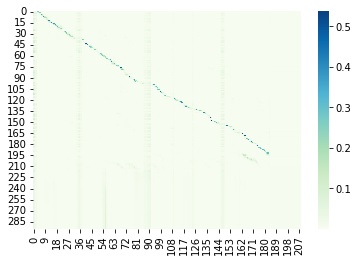

Updated Teacher Enforcing Rate =  1.0
Epoch 22/10 | Train Loss 0.4300 | Learning Rate 0.0002



Validation LD: 10.5843
Time lapsed = 0:19:45.082160
Time left = -1 day, 23:49:13.591549
Saving Checkpoint!

Epoch  23


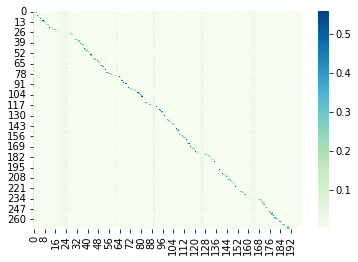

Updated Teacher Enforcing Rate =  0.96
Epoch 23/10 | Train Loss 0.4306 | Learning Rate 0.0002



Validation LD: 10.5411
Time lapsed = 0:39:21.852856
Time left = -1 day, 23:37:45.039690
Saving Model!
Saving Checkpoint!

Epoch  24


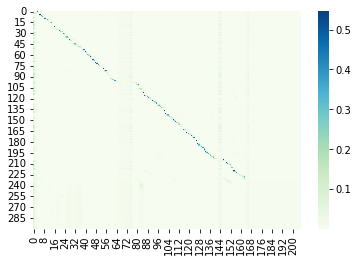

Updated Teacher Enforcing Rate =  0.9216
Epoch 24/10 | Train Loss 0.4300 | Learning Rate 0.0002



Validation LD: 10.8310
Time lapsed = 0:58:54.444684
Time left = -1 day, 23:25:38.240601
Saving Checkpoint!

Epoch  25


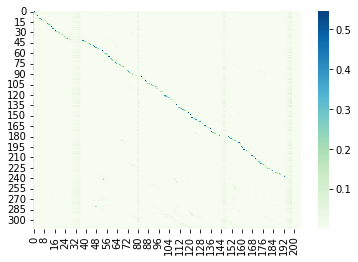

Updated Teacher Enforcing Rate =  0.884736
Epoch 25/10 | Train Loss 0.4289 | Learning Rate 0.0002



Validation LD: 11.3917
Time lapsed = 1:18:24.532811
Time left = -1 day, 23:12:57.280313
Saving Model!
Saving Checkpoint!

Epoch  26


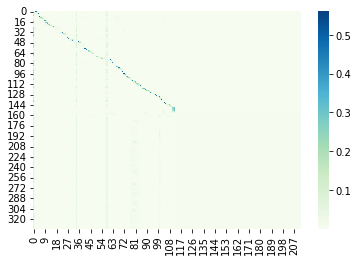

Updated Teacher Enforcing Rate =  0.84934656
Epoch 26/10 | Train Loss 0.4281 | Learning Rate 0.0002



Validation LD: 10.6820
Time lapsed = 1:37:50.109085
Time left = -1 day, 22:59:47.625178
Saving Checkpoint!

Epoch  27


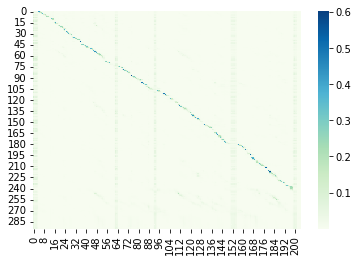

Updated Teacher Enforcing Rate =  0.8153726976
Epoch 27/10 | Train Loss 0.4273 | Learning Rate 0.0002



Validation LD: 10.7082
Time lapsed = 1:57:10.219741
Time left = -1 day, 22:46:13.565348
Saving Model!
Saving Checkpoint!

Epoch  28


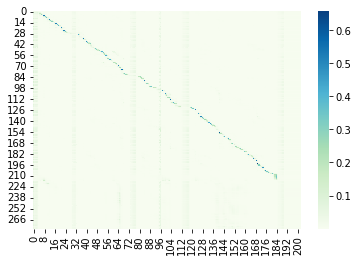

Updated Teacher Enforcing Rate =  0.782757789696
Epoch 28/10 | Train Loss 0.4276 | Learning Rate 0.0002



Validation LD: 10.4411
Time lapsed = 2:16:29.416606
Time left = -1 day, 22:32:15.375039
Saving Checkpoint!

Epoch  29


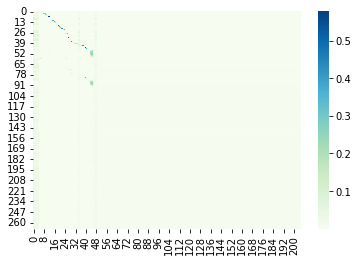

Updated Teacher Enforcing Rate =  0.7514474781081599
Epoch 29/10 | Train Loss 0.4262 | Learning Rate 0.0002



Validation LD: 10.5276
Time lapsed = 2:35:42.253397
Time left = -1 day, 22:17:59.213292
Saving Model!
Saving Checkpoint!

Epoch  30


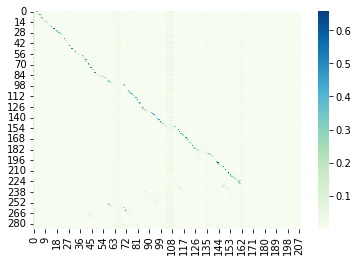

Updated Teacher Enforcing Rate =  0.7213895789838335
Epoch 30/10 | Train Loss 0.4263 | Learning Rate 0.0002



Validation LD: 10.6105
Time lapsed = 2:54:51.088681
Time left = -1 day, 22:03:25.940879
Saving Checkpoint!

Epoch  31


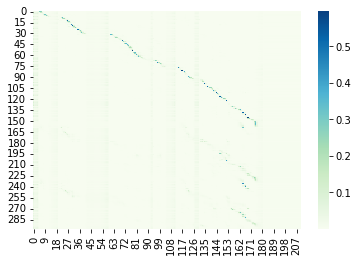

Updated Teacher Enforcing Rate =  0.6925339958244802
Epoch 31/10 | Train Loss 0.4254 | Learning Rate 0.0002



Validation LD: 10.9142
Time lapsed = 3:14:01.584246
Time left = -1 day, 21:48:33.765511
Saving Model!
Saving Checkpoint!
Saving Model!


Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Loss,▇█▇▆▅▄▄▂▂▁
Validation LD,▂▂▄█▃▃▁▂▂▄
Learning Rate,0.0002
Training Loss,0.42544
Validation LD,10.91424


In [ ]:
config = {
    '':'LAS-bigger-2head',
    'batch_size': 64,
    'epochs': 50,
    'scheduler': 'MultiStep',        # CALR, RLRP, MultiStep
    'optimizer': 'AdamP',            # SGD, Adam, AdamW, AdamP
    'sched': {'milestones' :[20*445, 35*445], 'gamma':0.5},   # MultiStep
    # 'sched': {'mode':'min', 'factor':0.5, 'patience':15, 'threshold':0.25, 'cooldown':15},  #RLRP     
    'optim': {'lr': 0.001, 'weight_decay': 5e-7},
    'seq2seq': {
        'input_dim': 13,
        'vocab_size': len(LETTER_LIST),
        'encoder_hidden_dim': 512, 
        'encoder_layers': 2,
        'decoder_hidden_dim': 512,
        'embed_dim': 512,
        'key_value_size': 256,
        'teacher_enforcing': 1.0,
        'downsampling': 2,
        'dropout': 0.0,
        'locked_dropout': 0.4
        },
    'weight_tying' : True,
    'label_smoothing' : 0.2,
    'save': True,
    'log': True,
    'randomize': False,
}

try:
    del attentionsr 
except Exception as e:
    print("Couldn't delete! ", e)

torch.cuda.empty_cache()
folder_path = r'/content/cmudrive/IDL/hw4-ablations'
attentionsr = ModelSetup(config, save_path = folder_path, toy=False)
attentionsr.dataloaders()

# torch.cuda.empty_cache()
# attentionsr.setup()

# *Continue Training
attentionsr.setup(continue_train=True, chkpt=21)
attentionsr.training(continue_train=True)
attentionsr.save_model()
if attentionsr.log: wandb.finish()
latest_model_name = attentionsr.model_name

--------------------------------------------------------------------------------
				TRAINING
--------------------------------------------------------------------------------


wandb: Currently logged in as: nefario7 (dl-study-group). Use `wandb login --relogin` to force relogin



Epoch  1


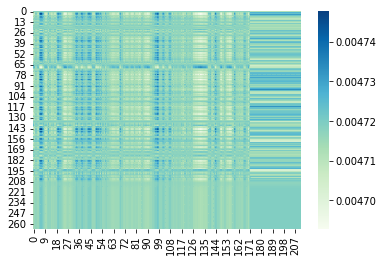

Updated Teacher Enforcing Rate =  1.0
Epoch 1/50 | Train Loss 1.4597 | Learning Rate 0.0010



Validation LD: 514.1493
Time lapsed = 0:19:49.495471
Time left = 16:11:25.278079
Saving Model!
Saving Checkpoint!

Epoch  2


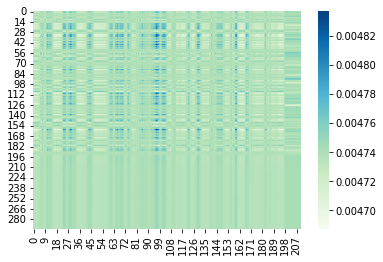

Updated Teacher Enforcing Rate =  1.0
Epoch 2/50 | Train Loss 1.1553 | Learning Rate 0.0010



Validation LD: 523.1195
Time lapsed = 0:39:42.191308
Time left = 15:52:52.591392
Saving Checkpoint!

Epoch  3


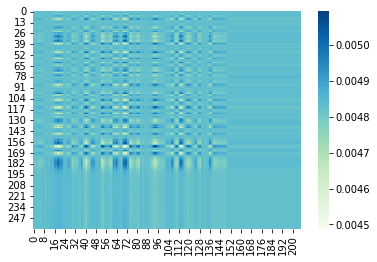

Updated Teacher Enforcing Rate =  1.0
Epoch 3/50 | Train Loss 1.1112 | Learning Rate 0.0010



Validation LD: 524.7943
Time lapsed = 0:59:37.895238
Time left = 15:34:13.692062
Saving Model!
Saving Checkpoint!

Epoch  4


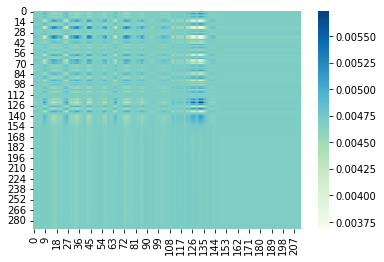

Updated Teacher Enforcing Rate =  1.0
Epoch 4/50 | Train Loss 1.0852 | Learning Rate 0.0010



Validation LD: 513.9982
Time lapsed = 1:19:32.145365
Time left = 15:14:39.671698
Saving Checkpoint!

Epoch  5


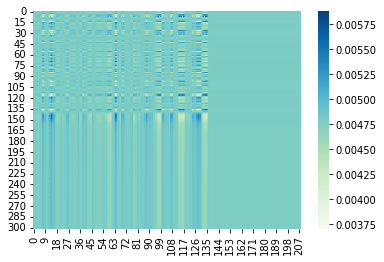

Updated Teacher Enforcing Rate =  1.0
Epoch 5/50 | Train Loss 1.0735 | Learning Rate 0.0010



Validation LD: 523.0967
Time lapsed = 1:39:29.521546
Time left = 14:55:25.693914
Saving Model!
Saving Checkpoint!

Epoch  6


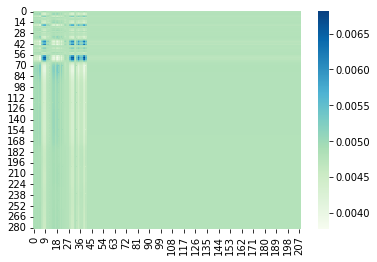

Updated Teacher Enforcing Rate =  1.0
Epoch 6/50 | Train Loss 1.0607 | Learning Rate 0.0010



Validation LD: 512.7282
Time lapsed = 1:59:30.025150
Time left = 14:36:20.184433
Saving Checkpoint!

Epoch  7


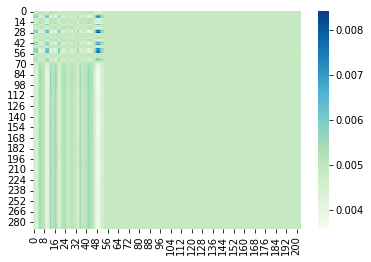

Updated Teacher Enforcing Rate =  1.0
Epoch 7/50 | Train Loss 1.0513 | Learning Rate 0.0010



Validation LD: 520.1744
Time lapsed = 2:19:29.084742
Time left = 14:16:50.091987
Saving Model!
Saving Checkpoint!

Epoch  8


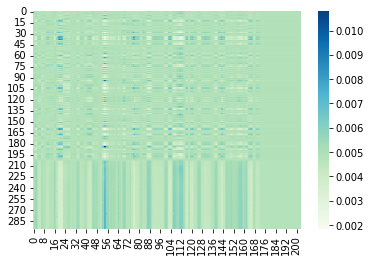

Updated Teacher Enforcing Rate =  1.0
Epoch 8/50 | Train Loss 1.0398 | Learning Rate 0.0010



Validation LD: 516.0778
Time lapsed = 2:39:29.365192
Time left = 13:57:19.167258
Saving Checkpoint!

Epoch  9


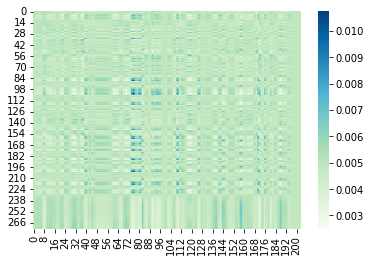

Updated Teacher Enforcing Rate =  1.0
Epoch 9/50 | Train Loss 1.0322 | Learning Rate 0.0010



Validation LD: 512.3539
Time lapsed = 2:59:27.803330
Time left = 13:37:33.326281
Saving Model!
Saving Checkpoint!

Epoch  10


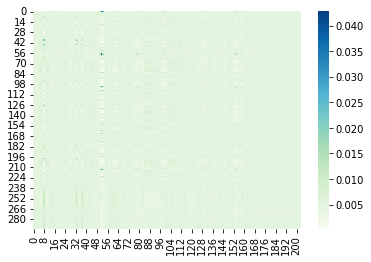

Updated Teacher Enforcing Rate =  1.0
Epoch 10/50 | Train Loss 1.0210 | Learning Rate 0.0010



Validation LD: 515.9764
Time lapsed = 3:19:28.742366
Time left = 13:17:54.969464
Saving Checkpoint!

Epoch  11


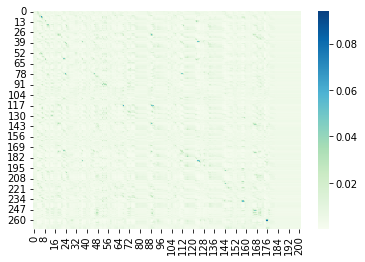

Updated Teacher Enforcing Rate =  1.0
Epoch 11/50 | Train Loss 1.0038 | Learning Rate 0.0010



Validation LD: 511.1948
Time lapsed = 3:39:35.045365
Time left = 12:58:31.524476
Saving Model!
Saving Checkpoint!

Epoch  12


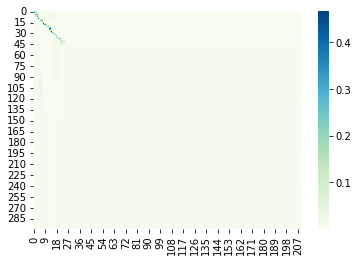

Updated Teacher Enforcing Rate =  1.0
Epoch 12/50 | Train Loss 0.7519 | Learning Rate 0.0010



Validation LD: 154.5120
Time lapsed = 3:59:43.864804
Time left = 12:39:08.905213
Saving Checkpoint!

Epoch  13


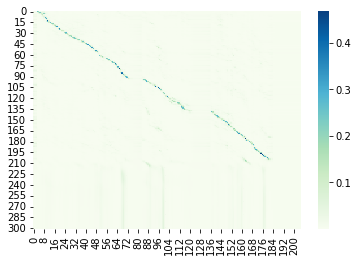

Updated Teacher Enforcing Rate =  1.0
Epoch 13/50 | Train Loss 0.5631 | Learning Rate 0.0010



Validation LD: 75.0214
Time lapsed = 4:19:52.526163
Time left = 12:19:38.728310
Saving Model!
Saving Checkpoint!

Epoch  14


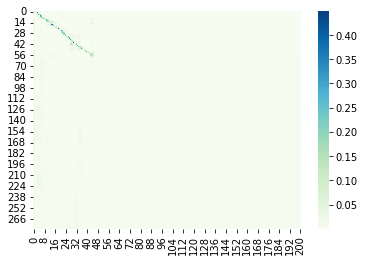

Updated Teacher Enforcing Rate =  1.0
Epoch 14/50 | Train Loss 0.5147 | Learning Rate 0.0010



Validation LD: 48.9818
Time lapsed = 4:39:59.765965
Time left = 11:59:59.398196
Saving Checkpoint!

Epoch  15


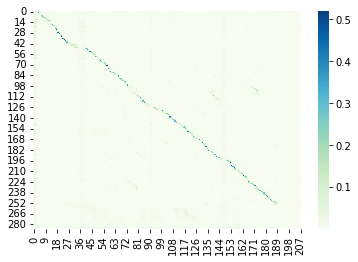

Updated Teacher Enforcing Rate =  0.96
Epoch 15/50 | Train Loss 0.4959 | Learning Rate 0.0010



Validation LD: 31.6123
Time lapsed = 5:00:01.868257
Time left = 11:40:04.359266
Saving Model!
Saving Checkpoint!

Epoch  16


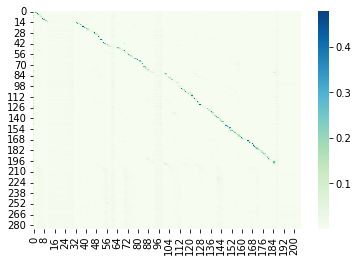

Updated Teacher Enforcing Rate =  0.9216
Epoch 16/50 | Train Loss 0.4828 | Learning Rate 0.0010



Validation LD: 27.5018
Time lapsed = 5:19:57.567856
Time left = 11:19:54.831694
Saving Checkpoint!

Epoch  17


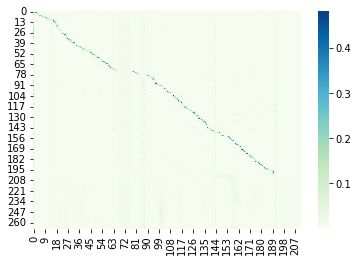

Updated Teacher Enforcing Rate =  0.884736
Epoch 17/50 | Train Loss 0.4725 | Learning Rate 0.0010



Validation LD: 22.2427
Time lapsed = 5:39:49.489837
Time left = 10:59:39.597919
Saving Model!
Saving Checkpoint!

Epoch  18


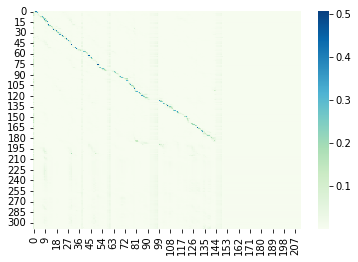

Updated Teacher Enforcing Rate =  0.84934656
Epoch 18/50 | Train Loss 0.4664 | Learning Rate 0.0010



Validation LD: 20.8997
Time lapsed = 5:59:35.567550
Time left = 10:39:16.564533
Saving Checkpoint!

Epoch  19


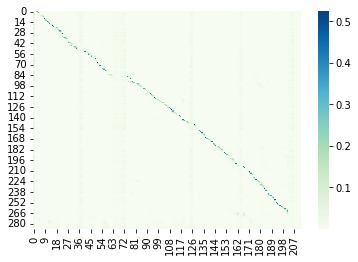

Updated Teacher Enforcing Rate =  0.8153726976
Epoch 19/50 | Train Loss 0.4607 | Learning Rate 0.0010



Validation LD: 17.3027
Time lapsed = 6:19:14.765465
Time left = 10:18:46.196285
Saving Model!
Saving Checkpoint!

Epoch  20


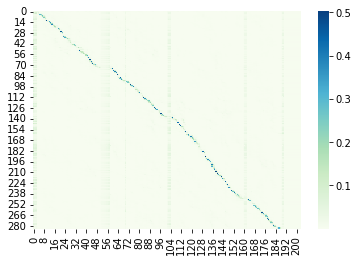

Updated Teacher Enforcing Rate =  0.782757789696
Epoch 20/50 | Train Loss 0.4573 | Learning Rate 0.0005



Validation LD: 16.5262
Time lapsed = 6:38:54.158153
Time left = 9:58:21.237230
Saving Checkpoint!

Epoch  21


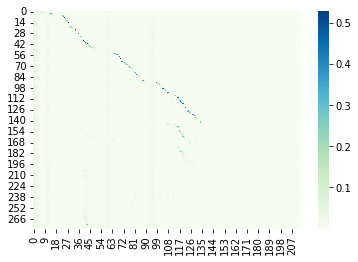

Updated Teacher Enforcing Rate =  0.7514474781081599
Epoch 21/50 | Train Loss 0.4412 | Learning Rate 0.0005



Validation LD: 12.0047
Time lapsed = 6:58:29.058673
Time left = 9:37:54.414358
Saving Model!
Saving Checkpoint!

Epoch  22


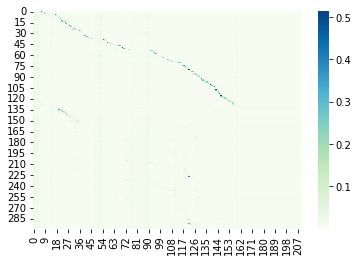

Updated Teacher Enforcing Rate =  0.7213895789838335
Epoch 22/50 | Train Loss 0.4355 | Learning Rate 0.0005



Validation LD: 12.3757
Time lapsed = 7:18:00.134391
Time left = 9:17:27.443770
Saving Checkpoint!

Epoch  23


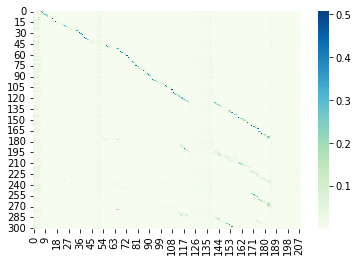

Updated Teacher Enforcing Rate =  0.6925339958244802
Epoch 23/50 | Train Loss 0.4332 | Learning Rate 0.0005



Validation LD: 11.7231
Time lapsed = 7:37:32.209110
Time left = 8:57:06.506347
Saving Model!
Saving Checkpoint!

Epoch  24


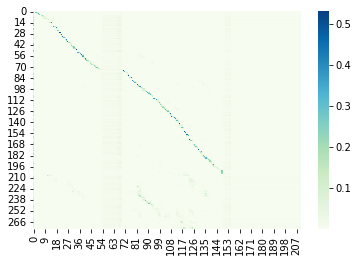

Updated Teacher Enforcing Rate =  0.6648326359915009
Epoch 24/50 | Train Loss 0.4320 | Learning Rate 0.0005



Validation LD: 11.7820
Time lapsed = 7:57:00.491941
Time left = 8:36:45.532936
Saving Checkpoint!

Epoch  25


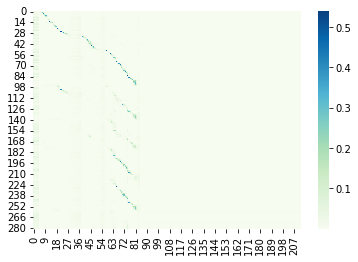

Updated Teacher Enforcing Rate =  0.6382393305518408
Epoch 25/50 | Train Loss 0.4322 | Learning Rate 0.0005



Validation LD: 12.5189
Time lapsed = 8:16:29.840014
Time left = 8:16:29.840014
Saving Model!
Saving Checkpoint!

Epoch  26


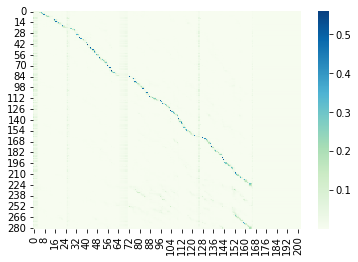

Updated Teacher Enforcing Rate =  0.6127097573297672
Epoch 26/50 | Train Loss 0.4320 | Learning Rate 0.0005



Validation LD: 11.7991
Time lapsed = 8:35:55.449829
Time left = 7:56:14.261381
Saving Checkpoint!

Epoch  27


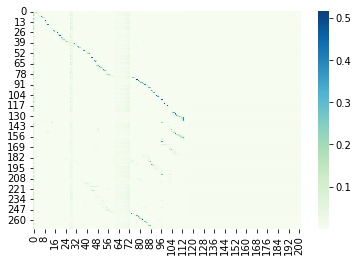

Updated Teacher Enforcing Rate =  0.5882013670365764
Epoch 27/50 | Train Loss 0.4331 | Learning Rate 0.0005



Validation LD: 11.0941
Time lapsed = 8:55:18.803119
Time left = 7:36:00.461916
Saving Model!
Saving Checkpoint!

Epoch  28


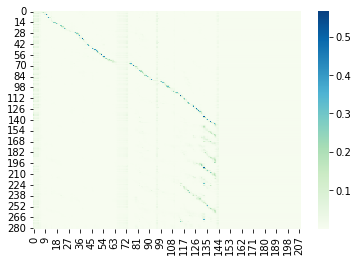

Updated Teacher Enforcing Rate =  0.5646733123551133
Epoch 28/50 | Train Loss 0.4316 | Learning Rate 0.0005



Validation LD: 11.9132
Time lapsed = 9:14:39.381699
Time left = 7:15:48.085621
Saving Checkpoint!

Epoch  29


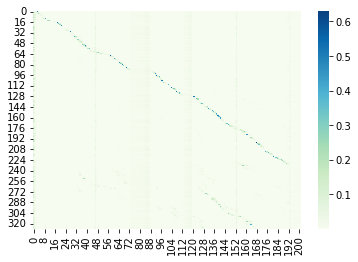

Updated Teacher Enforcing Rate =  0.5420863798609088
Epoch 29/50 | Train Loss 0.4324 | Learning Rate 0.0005



Validation LD: 12.2409
Time lapsed = 9:33:55.377345
Time left = 6:55:35.962905
Saving Model!
Saving Checkpoint!

Epoch  30


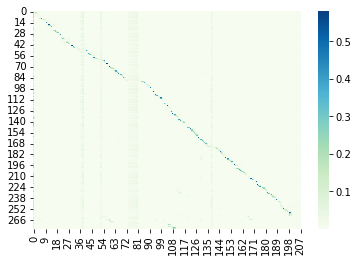

Updated Teacher Enforcing Rate =  0.5204029246664724
Epoch 30/50 | Train Loss 0.4286 | Learning Rate 0.0005



Validation LD: 11.8870
Time lapsed = 9:53:06.863902
Time left = 6:35:24.575935
Saving Checkpoint!

Epoch  31


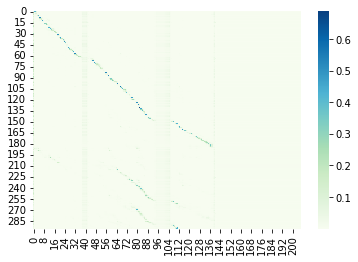

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 31/50 | Train Loss 0.4309 | Learning Rate 0.0005



Validation LD: 11.7627
Time lapsed = 10:12:16.618633
Time left = 6:15:15.992065
Saving Model!
Saving Checkpoint!

Epoch  32


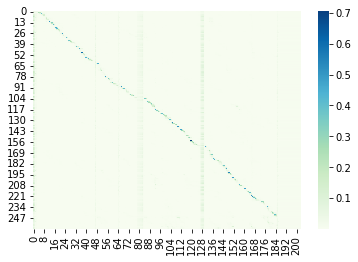

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 32/50 | Train Loss 0.4300 | Learning Rate 0.0005



Validation LD: 12.1871
Time lapsed = 10:31:24.555968
Time left = 5:55:10.062732
Saving Checkpoint!

Epoch  33


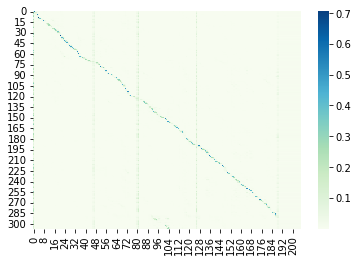

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 33/50 | Train Loss 0.4283 | Learning Rate 0.0005



Validation LD: 11.1602
Time lapsed = 10:50:36.506636
Time left = 5:35:09.715540
Saving Model!
Saving Checkpoint!

Epoch  34


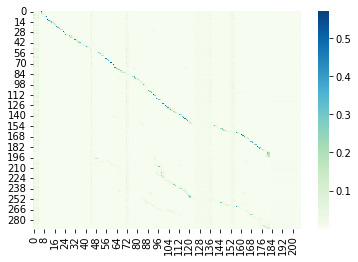

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 34/50 | Train Loss 0.4269 | Learning Rate 0.0005



Validation LD: 10.5069
Time lapsed = 11:09:50.627235
Time left = 5:15:13.236346
Saving Checkpoint!

Epoch  35


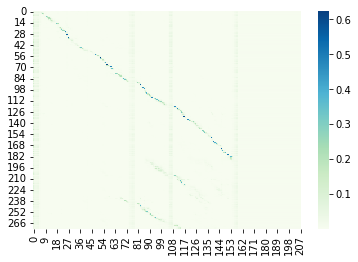

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 35/50 | Train Loss 0.4267 | Learning Rate 0.0003



Validation LD: 11.1290
Time lapsed = 11:29:00.385444
Time left = 4:55:17.308047
Saving Model!
Saving Checkpoint!

Epoch  36


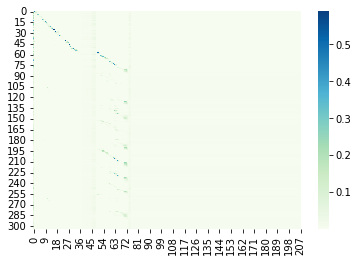

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 36/50 | Train Loss 0.4215 | Learning Rate 0.0003



Validation LD: 9.6988
Time lapsed = 11:48:11.048305
Time left = 4:35:24.296563
Saving Checkpoint!

Epoch  37


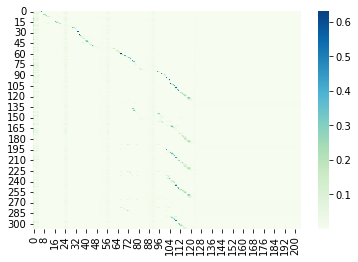

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 37/50 | Train Loss 0.4193 | Learning Rate 0.0003



Validation LD: 10.3866
Time lapsed = 12:07:20.985477
Time left = 4:15:33.319222
Saving Model!
Saving Checkpoint!

Epoch  38


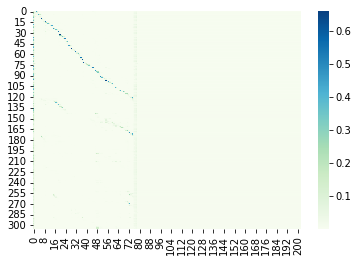

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 38/50 | Train Loss 0.4188 | Learning Rate 0.0003



Validation LD: 9.0349
Time lapsed = 12:26:34.111111
Time left = 3:55:45.508772
Saving Checkpoint!

Epoch  39


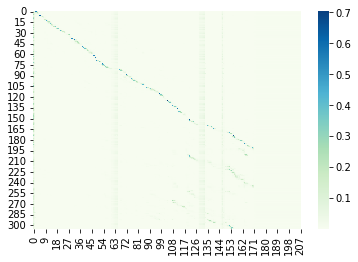

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 39/50 | Train Loss 0.4178 | Learning Rate 0.0003



Validation LD: 8.9597
Time lapsed = 12:45:41.618419
Time left = 3:35:57.892375
Saving Model!
Saving Checkpoint!

Epoch  40


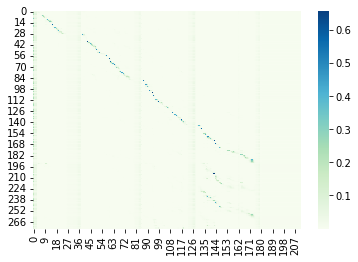

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 40/50 | Train Loss 0.4186 | Learning Rate 0.0003



Validation LD: 9.0701
Time lapsed = 13:04:52.582414
Time left = 3:16:13.145604
Saving Checkpoint!

Epoch  41


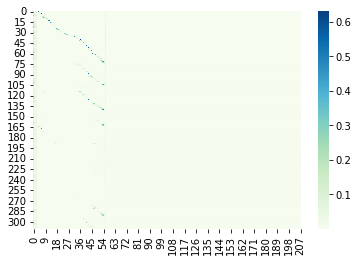

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 41/50 | Train Loss 0.4187 | Learning Rate 0.0003



Validation LD: 10.1512
Time lapsed = 13:24:02.751684
Time left = 2:56:29.872321
Saving Model!
Saving Checkpoint!

Epoch  42


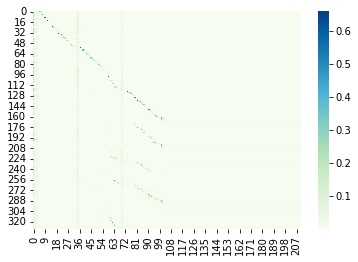

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 42/50 | Train Loss 0.4186 | Learning Rate 0.0003



Validation LD: 9.6701
Time lapsed = 13:43:17.604564
Time left = 2:36:49.067536
Saving Checkpoint!

Epoch  43


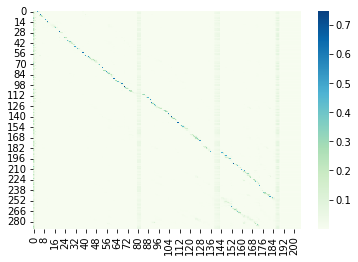

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 43/50 | Train Loss 0.4196 | Learning Rate 0.0003



Validation LD: 10.3056
Time lapsed = 14:02:26.710163
Time left = 2:17:08.534213
Saving Model!
Saving Checkpoint!

Epoch  44


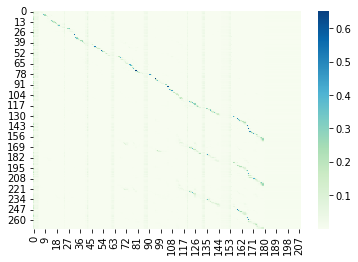

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 44/50 | Train Loss 0.4182 | Learning Rate 0.0003



Validation LD: 9.7798
Time lapsed = 14:21:37.967128
Time left = 1:57:29.722790
Saving Checkpoint!

Epoch  45


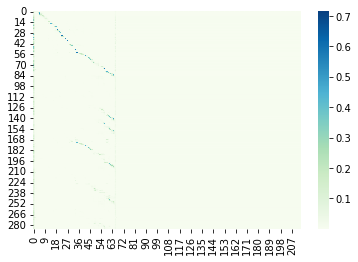

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 45/50 | Train Loss 0.4192 | Learning Rate 0.0003



Validation LD: 10.2031
Time lapsed = 14:40:46.128473
Time left = 1:37:51.792053
Saving Model!
Saving Checkpoint!

Epoch  46


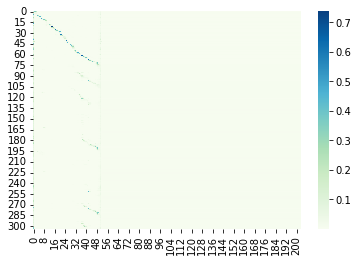

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 46/50 | Train Loss 0.4183 | Learning Rate 0.0003



Validation LD: 9.9488
Time lapsed = 14:59:54.842234
Time left = 1:18:15.203673
Saving Checkpoint!

Epoch  47


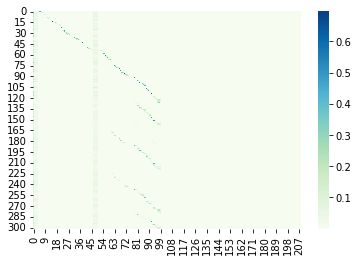

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 47/50 | Train Loss 0.4173 | Learning Rate 0.0003



Validation LD: 9.3877
Time lapsed = 15:19:05.506117
Time left = 0:58:39.925922
Saving Model!
Saving Checkpoint!

Epoch  48


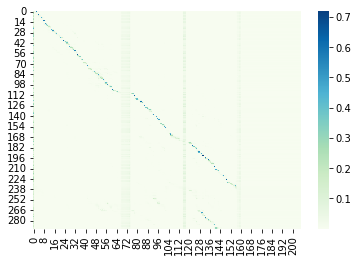

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 48/50 | Train Loss 0.4191 | Learning Rate 0.0003



Validation LD: 10.5770
Time lapsed = 15:38:18.006639
Time left = 0:39:05.750277
Saving Checkpoint!

Epoch  49


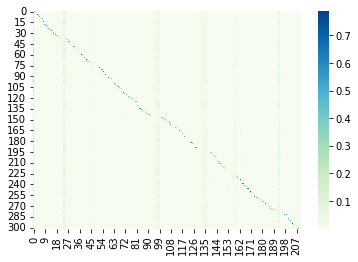

Updated Teacher Enforcing Rate =  0.4995868076798135
Epoch 49/50 | Train Loss 0.4182 | Learning Rate 0.0003



Validation LD: 9.9535
Time lapsed = 15:57:25.734946
Time left = 0:19:32.361938
Saving Model!
Saving Checkpoint!

Epoch  50


Train:  40%|███▉      | 176/445 [07:10<10:55,  2.44s/it, loss=0.4168, lr=0.0003]

In [ ]:
torch.cuda.empty_cache()
attentionsr.training()
attentionsr.save_model()

if attentionsr.log: wandb.finish()
latest_model_name = attentionsr.model_name

# Inference

In [ ]:
class SpeechInference():
    def __init__(self, bw=30):
        self.drive_dir = r'/content/cmudrive/IDL'

        # Dataset and dataloader
        self.test_data = LibriSamples(partition='test')
        self.test_loader = DataLoader(
            self.test_data, 
            batch_size=128, 
            shuffle=False, 
            drop_last=False,
            collate_fn = self.test_data.collate_fn
            )
        
        # self.decoder = CTCBeamDecoder(
        #         LETTER_LIST,
        #         blank_id=0,
        #         log_probs_input=True,
        #         beam_width=bw, 
        #         cutoff_top_n= 40,
        #         cutoff_prob= 1.0
        # )
        
    def get_predictions(self, model):
        predictions = []
        model.eval()
        with torch.no_grad():
            for i, (x, x_len) in enumerate(tqdm(self.test_loader, desc="Test")):
                torch.cuda.empty_cache()
                x = x.to(device)
                output, _ = model(x, x_len, mode='eval')

                # BEAM SEARCH
                # beam_results, beam_scores, timesteps, out_lens = self.decoder.decode(output, seq_lens=output_len)
                # for b in range(output.shape[0]):
                #     predictions.append(convert_to_string(beam_results[b][0], out_lens[b][0], self.phoneme_map, self.phonemes))

                # GREEDY SEARCH
                greedy_output = output.argmax(-1).detach().cpu().numpy()
                predictions.extend(convert_to_string(greedy_output))

        return predictions

    def load_model(self): 
        self.main_path = os.path.join(self.drive_dir, self.model_type, self.model_name)
        meta_path = os.path.join(self.main_path, 'model_config.yaml')
        model_path = os.path.join(self.main_path, self.model_file)
        
        with open(meta_path, 'r') as meta:
            args = yaml.safe_load(meta)

        model = Seq2Seq(**args["seq2seq"]).to(device)
        model.load_state_dict(torch.load(model_path))
        return model

    def simple_inference(self, model_name, model_file, model_type):
        print("Running inference...")
        self.model_type = model_type
        self.model_name = model_name
        self.model_file = model_file
        self.timestamp = datetime.datetime.utcnow().strftime('%Y-%m-%d_%H-%M-%S')
        model = self.load_model()
        preds = self.get_predictions(model)
        return preds

    def write_csv(self, path, preds):
        with open(path, 'w') as f:
            csvwrite = csv.writer(f)
            csvwrite.writerow(['id', 'predictions'])
            for i in range(len(preds)):
                csvwrite.writerow([i, preds[i]])

    def generate_submission(self, save_path, preds): 
        print("Generating Submission CSV...")
        sub_dir = os.path.join(self.drive_dir, save_path, self.timestamp)
        mod_dir = os.path.join(self.main_path, self.timestamp)

        try:
            os.mkdir(sub_dir)
            os.mkdir(mod_dir)
        except:
            print("Couldn't create folder for submission.csv")
            
        sub_path = os.path.join(sub_dir, 'submission.csv')
        mod_path = os.path.join(mod_dir, 'submission.csv')

        self.write_csv(sub_path, preds)
        self.write_csv(mod_path, preds)

        print(f"File saved at : {sub_path}")
        print(f"File saved in model at : {mod_path}")
        return sub_path

In [ ]:
model_name = 'LAS-bigger-2head-13-30-512-2-512-512-256-1.0-2-0.0-0.4_b64_e50_sMultiStep_oAdamP_lr0.001'
# model_name = latest_model_name

model_type = r'hw4-ablations'
sub_path = r'hw4-submission'
model_file = 'model_34.pth'

inference = SpeechInference()

predictions = inference.simple_inference(model_name, model_file, model_type)
submission_path = inference.generate_submission(sub_path, predictions)

print("\n\nSubmission File : ", submission_path)

MFCC: 100%|██████████| 2620/2620 [00:01<00:00, 2485.61it/s]


Running inference...


Test: 100%|██████████| 21/21 [00:50<00:00,  2.42s/it]


Generating Submission CSV...
File saved at : /content/cmudrive/IDL/hw4-submission/2022-05-04_22-12-13/submission.csv
File saved in model at : /content/cmudrive/IDL/hw4-ablations/LAS-bigger-2head-13-30-512-2-512-512-256-1.0-2-0.0-0.4_b64_e50_sMultiStep_oAdamP_lr0.001/2022-05-04_22-12-13/submission.csv


Submission File :  /content/cmudrive/IDL/hw4-submission/2022-05-04_22-12-13/submission.csv


In [ ]:
print(f"Preview of submission.csv")
df = pd.read_csv(submission_path)
df.head(10)
df.iloc[0]['predictions']

Preview of submission.csv


'HE BEGAN A CONFUSED COMPLAINT AGAINST THE WHISTER WHO ADVANTAGE BEHIND THE CURT ON THE LEFT'

In [ ]:
!kaggle competitions submit -c 11-785-s22-hw4p2 -f $submission_path -m "LAS-bigger-2head"


100% 296k/296k [00:06<00:00, 50.0kB/s]
Successfully submitted to Attention-Based Speech Recognition

In [ ]:
!kaggle competitions submit -c 11-785-s22-hw4p2-slack -f $submission_path -m "LAS-bigger-2head"

100% 296k/296k [00:06<00:00, 49.9kB/s]
Successfully submitted to Attention-Based Speech Recognition (Slack)